In [ ]:
import os
import json
os.system("""

curl -X POST --data '{
    "jsonrpc": "2.0",
    "method": "platform.getCurrentSupply",
    "params": {},
    "id": 1
}' -H 'content-type:application/json;' https://api.avax.network/ext/P > supply.json

""")

with open("supply.json","r") as file:
    supply_query = float(json.load(file)['result']['supply'])
    supply_query = supply_query / (10**15) # convert to millions
    print(supply_query)

420.1819972300459


In [ ]:
"""
All units of time are in weeks
All untis of tokens are in Mega (10^6) AVAX
Assuming the uptime requirements (>80%) for all validators is met
"""
import math
import pandas as pd

MIN_RATE = .1
MAX_RATE = .12
MIN_LOCKUP = 2
MAX_LOCKUP = 52

MAX_TOKENS = 720
# INITIAL_SUPPLY = 401.88 # assumed starting point because history is over (https://vscout.io/ as of Mar '22)
INITIAL_SUPPLY = supply_query # assuming currrent supply per API
INITIAL_STAKING_RATIO = .6631 # staking ratio (https://www.avax.network/validators as of April '22)

def reward(lockup # selected lockup in weeks
            , amt_staked # selected Mega AVAX staked
            , current_supply # current global supply of Mega AVAX that could be staked, *** TAKEN AT THE BEGINNING OF LOCKUP
           ):
    """
    per the comments in the code: https://github.com/ava-labs/avalanchego/blob/e388a890b6c02c0f58fd116357fe508e65bb1c42/vms/platformvm/reward/calculator.go

    // Reward returns the amount of tokens to reward the staker with.
    //
    // RemainingSupply = SupplyCap - ExistingSupply
    // PortionOfExistingSupply = StakedAmount / ExistingSupply
    // PortionOfStakingDuration = StakingDuration / MaximumStakingDuration
    // MintingRate = MinMintingRate + MaxSubMinMintingRate * PortionOfStakingDuration
    // Reward = RemainingSupply * PortionOfExistingSupply * MintingRate * PortionOfStakingDuration
    """
    
    current_unminted = MAX_TOKENS - current_supply # gets reduced as current_supply rises
    portion_of_current_supply = amt_staked / current_supply # gets reduced as current_supply rises
    ratio_of_lockup_to_max = lockup / MAX_LOCKUP
    minting_rate = ((MAX_RATE - MIN_RATE) * ratio_of_lockup_to_max) + MIN_RATE
    
    reward = current_unminted * portion_of_current_supply * minting_rate * ratio_of_lockup_to_max
        
    return reward 

In [ ]:
stake = .7 #700k or .7M - arbitrary

reward_52 = reward(52, stake, INITIAL_SUPPLY) / stake
reward_4 = reward(4, stake, INITIAL_SUPPLY) * 52/4 / stake

print('Est. rewards for 52 week lockup', f"{reward_52:.4f}")
print('Est. rewards for 4 week lockup (no compounding + no increase in supply, which isn\'t true in reality)', f"{reward_4:.4f}")


Est. rewards for 52 week lockup 0.0856
Est. rewards for 4 week lockup (no compounding + no increase in supply, which isn't true in reality) 0.0725


In [ ]:
# 4 weeks at a time auto compounding + estimating supply
t_stake = stake
t_supply = INITIAL_SUPPLY
for i in range(int(52/4)):
  reward_4 = reward(4, t_stake, t_supply)
  global_reward = reward(4, (MAX_TOKENS * INITIAL_STAKING_RATIO), t_supply) # roughly estimated inflation -- avg. period staked would likely be higher, but % of network staked could be lower over time
  t_stake += reward_4
  # print(reward_4, t_stake, global_reward)
  t_supply += (reward_4 + global_reward) # reward + roughly estimated inflation

print((t_stake / stake) - 1)

0.06854655408289512


In [ ]:
# 4 weeks at a time no compounding + estimating supply
t_stake = stake
reward_sum = 0
t_supply = INITIAL_SUPPLY
for i in range(int(52/4)):
  reward_4 = reward(4, t_stake, t_supply)
  global_reward = reward(4, (MAX_TOKENS * INITIAL_STAKING_RATIO), t_supply) # roughly estimated inflation -- avg. period staked would likely be higher, but % of network staked could be lower over time
  reward_sum += reward_4
  # print(reward_4, t_stake, global_reward)
  t_supply += (reward_4 + global_reward) # reward + roughly estimated inflation

print(((t_stake + reward_sum)/ stake) - 1)

0.06646935234777152


In [ ]:
# 2 weeks at a time no compounding + constant supply
t_stake = stake
reward_sum = 0
t_supply = INITIAL_SUPPLY
for i in range(int(52/2)):
  reward_4 = reward(2, t_stake, t_supply)
  #global_reward = reward(4, (MAX_TOKENS * INITIAL_STAKING_RATIO), t_supply) # roughly estimated inflation -- avg. period staked would likely be higher, but % of network staked could be lower over time
  reward_sum += reward_4
  # print(reward_4, t_stake, global_reward)
  #t_supply += (reward_4 + global_reward) # reward + roughly estimated inflation

print(((t_stake + reward_sum)/ stake) - 1)

0.07190319839751336


In [ ]:
import matplotlib.pyplot as plt
IPython_default = plt.rcParams.copy()
plt.style.use('fivethirtyeight')
print(plt.style.available[:100])

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [ ]:
# flat_supply_by_week = []
# for w in range(2, 53):
#   # X weeks at a time auto compounding + assuming flat supply -- not true
#   t_stake = stake
#   t_supply = INITIAL_SUPPLY

#   left_over = int(52 - math.floor(52/w) * w)
#   if (left_over != int(52 % w)):
#     print('here!',w)
#   for i in range(int(math.floor(52/w))):
#     reward_4 = reward(w, t_stake, t_supply)
#     #global_reward = reward(4, (MAX_TOKENS * INITIAL_STAKING_RATIO), t_supply) # roughly estimated inflation -- avg. period staked would likely be higher, but % of network staked could be lower over time
#     t_stake += reward_4
#     # print(reward_4, t_stake, global_reward)
#     #t_supply += (reward_4 + global_reward) # reward + roughly estimated inflation
#   if left_over > 0:
#     reward_4 = reward(left_over, t_stake, t_supply) # if just 1, not techinally allowed, but will assume user would smooth out
#     #global_reward = reward(4, (MAX_TOKENS * INITIAL_STAKING_RATIO), t_supply) # roughly estimated inflation -- avg. period staked would likely be higher, but % of network staked could be lower over time
#     t_stake += reward_4
#     # print(reward_4, t_stake, global_reward)
#     #t_supply += (reward_4 + global_reward) # reward + roughly estimated inflation
#   flat_supply_by_week.append((w,((t_stake / stake) - 1)))

# df = pd.DataFrame(flat_supply_by_week,columns=['Week','Annualized Reward Rate']).set_index('Week')

# df.plot(figsize=(15,10))

0.07444468595083897
0.07492503955900642
0.07705343484532534
0.08002991117244429
0.08562518282451959


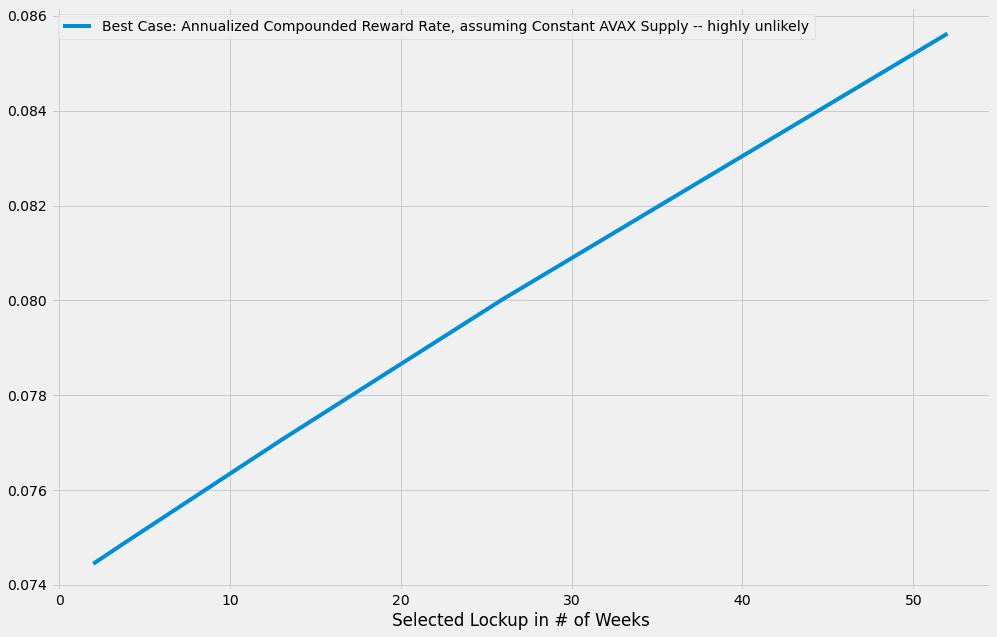

In [ ]:
flat_supply_by_week = []
for w in [2,4,13,26,52]:
  # X weeks at a time auto compounding + assuming flat supply -- not true
  t_stake = stake
  t_supply = INITIAL_SUPPLY
  total_reward = 0

  left_over = int(52 - math.floor(52/w) * w)
  if (left_over != int(52 % w)):
    print('here!',w)
  for i in range(int(math.floor(52/w))):
    reward_4 = reward(w, t_stake, t_supply)
    #global_reward = reward(4, (MAX_TOKENS * INITIAL_STAKING_RATIO), t_supply) # roughly estimated inflation -- avg. period staked would likely be higher, but % of network staked could be lower over time
    total_reward += reward_4
    t_stake += reward_4
    # print(reward_4, t_stake, global_reward)
    #t_supply += (reward_4 + global_reward) # reward + roughly estimated inflation
  if left_over > 0:
    print('error',left_over)
    reward_4 = reward(left_over, t_stake, t_supply) # if just 1, not techinally allowed, but will assume user would smooth out
    #global_reward = reward(4, (MAX_TOKENS * INITIAL_STAKING_RATIO), t_supply) # roughly estimated inflation -- avg. period staked would likely be higher, but % of network staked could be lower over time
    t_stake += reward_4
    # print(reward_4, t_stake, global_reward)
    #t_supply += (reward_4 + global_reward) # reward + roughly estimated inflation
  flat_supply_by_week.append((w,(((stake + total_reward) / stake) - 1)))
  print(((t_stake / stake) - 1))

df = pd.DataFrame(flat_supply_by_week,columns=['Selected Lockup in # of Weeks','Best Case: Annualized Compounded Reward Rate, assuming Constant AVAX Supply -- highly unlikely']).set_index('Selected Lockup in # of Weeks')

df.plot(figsize=(15,10))

0.04932348826666015 0.07046212609522873
0.049728594474679366 0.07104084924954202
0.05156790310326041 0.07366843300465775
0.054277764749868354 0.0775396639283834
0.059937627977163746 0.08562518282451959


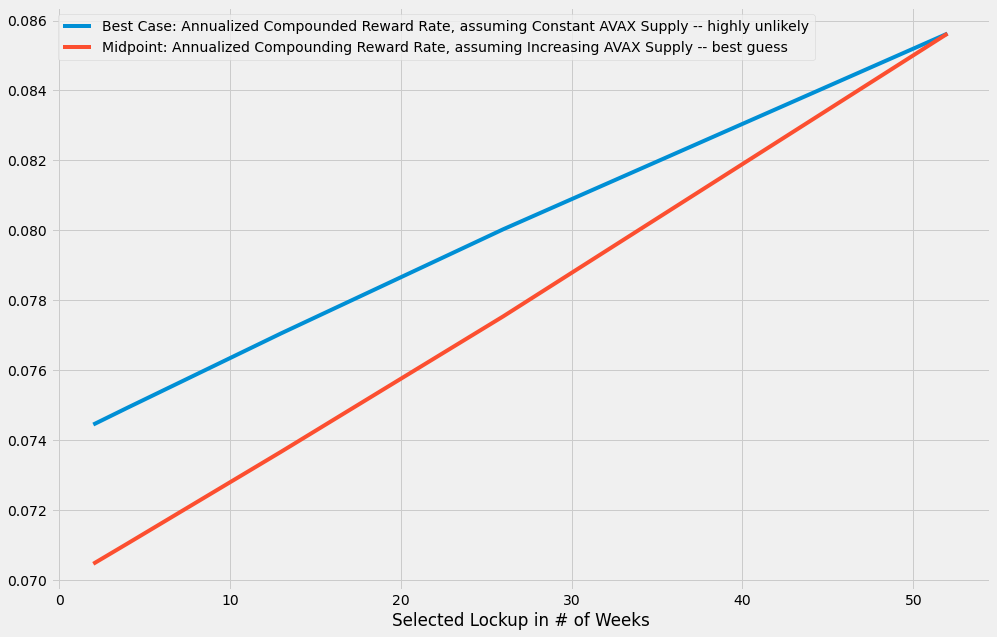

In [ ]:
incr_supply_by_week = []
for w in [2,4,13,26,52]:
  # X weeks at a time auto compounding + assuming flat supply -- not true
  t_stake = stake
  t_supply = INITIAL_SUPPLY
  total_reward = 0
  left_over = int(52 - math.floor(52/w) * w)
  if (left_over != int(52 % w)):
    print('here!',w)
  for i in range(int(math.floor(52/w))):
    reward_4 = reward(w, t_stake, t_supply)
    global_reward = reward(w, (INITIAL_SUPPLY * INITIAL_STAKING_RATIO), t_supply) # roughly estimated inflation -- avg. period staked would likely be higher, but % of network staked could be lower over time
    total_reward += reward_4
    t_stake += reward_4
    #print(reward_4, t_stake, global_reward)
    t_supply += (reward_4 + global_reward) # reward + roughly estimated inflation
  if left_over > 0:
    print('error',left_over)
  incr_supply_by_week.append((w,(((total_reward+stake) / stake) - 1)))
  print(total_reward, (((total_reward+stake) / stake) - 1))
df2 = pd.DataFrame(incr_supply_by_week,columns=['Selected Lockup in # of Weeks','place_holder']).set_index('Selected Lockup in # of Weeks')

df['Midpoint: Annualized Compounding Reward Rate, assuming Increasing AVAX Supply -- best guess'] = df2['place_holder']

df.plot(figsize=(15,10))

0.045448599614392925 0.06492657087770426
0.046014989942867866 0.06573569991838268
0.048581745167220636 0.0694024930960293
0.052333341591725493 0.07476191655960784
0.059937627977163746 0.08562518282451959
<class 'matplotlib.axes._subplots.AxesSubplot'>


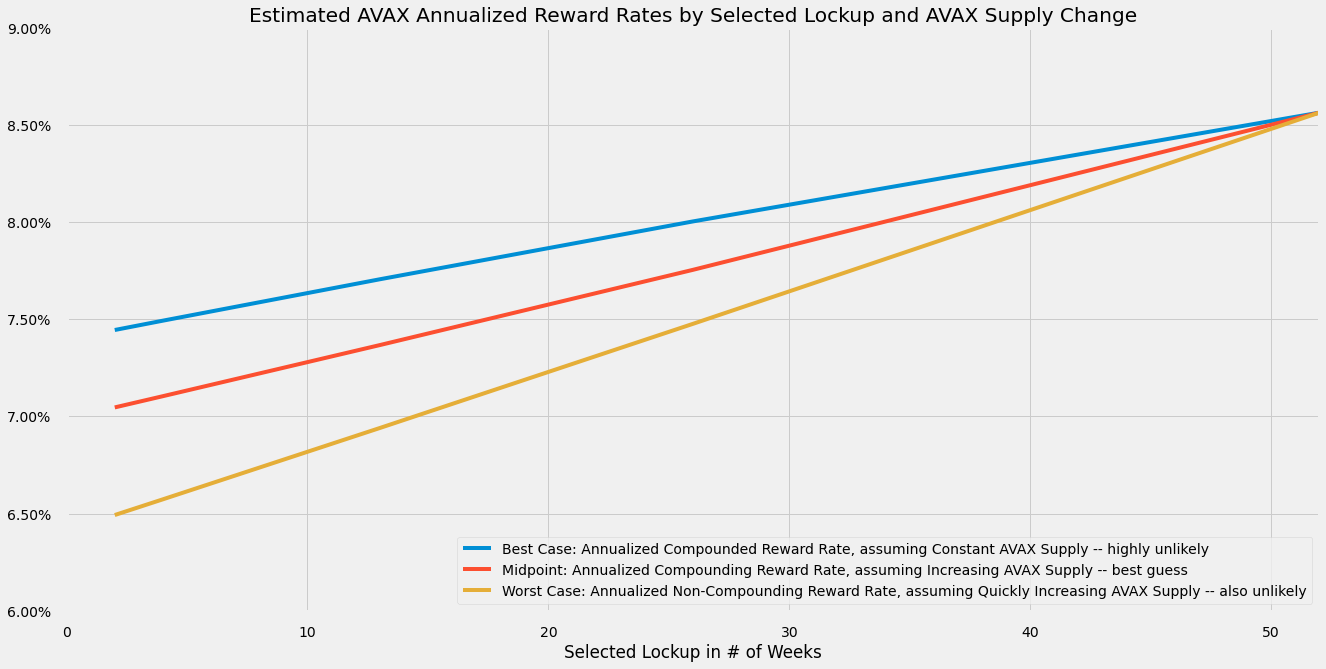

In [ ]:
incr_supply_by_week = []
for w in [2,4,13,26,52]:
  # X weeks at a time auto compounding + assuming flat supply -- not true
  t_stake = stake
  t_supply = INITIAL_SUPPLY
  total_reward = 0
  left_over = int(52 - math.floor(52/w) * w)
  if (left_over != int(52 % w)):
    print('here!',w)
  for i in range(int(math.floor(52/w))):
    reward_4 = reward(w, t_stake, t_supply)
    global_reward = reward(52, (INITIAL_SUPPLY * INITIAL_STAKING_RATIO), t_supply) # roughly estimated inflation -- avg. period staked would likely be higher, but % of network staked could be lower over time
    total_reward += reward_4
    t_stake += reward_4
    #print(reward_4, t_stake, global_reward)
    if i == 0:
      #print(t_supply)
      t_supply += (reward_4 + global_reward) # reward + roughly estimated inflation
      #print(t_supply)
  if left_over > 0:
    print('error',left_over)
  incr_supply_by_week.append((w,(((total_reward+stake) / stake) - 1)))
  print(total_reward, (((total_reward+stake) / stake) - 1))
df2 = pd.DataFrame(incr_supply_by_week,columns=['Selected Lockup in # of Weeks','place_holder']).set_index('Selected Lockup in # of Weeks')

df['Worst Case: Annualized Non-Compounding Reward Rate, assuming Quickly Increasing AVAX Supply -- also unlikely'] = df2['place_holder']

ax = df.plot(figsize=(20,10), title='Estimated AVAX Annualized Reward Rates by Selected Lockup and AVAX Supply Change',xlim=(0,52),ylim=(.06,.09))
ax.legend(loc='lower right')
print(type(ax))  # matplotlib.axes._subplots.AxesSubplot

# manipulate
yticks = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in yticks])
ax.tick_params(axis="y",direction="out", pad=15)
ax.tick_params(axis="x",direction="out", pad=15)

In [ ]:
from google.colab import files # specific to running in colab

df.to_csv('output.csv')
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# inc50_supply_by_week = []
# for w in range(2, 53):
#   # 4 weeks at a time auto compounding + assuming flat supply -- not true
#   t_stake = stake
#   t_supply = INITIAL_SUPPLY

#   left_over = int(52 - math.floor(52/w) * w)
#   if (left_over != int(52 % w)):
#     print('here!',w)
#   for i in range(int(math.floor(52/w))):
#     reward_4 = reward(w, t_stake, t_supply)
    
#     t_stake += reward_4
#     # print(reward_4, t_stake, global_reward)
#     #t_supply += (reward_4 + global_reward) # reward + roughly estimated inflation
#   if left_over > 0:
#     reward_4 = reward(left_over, t_stake, t_supply) # if just 1, not techinally allowed, but will assume user would smooth out
#     #global_reward = reward(4, (MAX_TOKENS * INITIAL_STAKING_RATIO), t_supply) # roughly estimated inflation -- avg. period staked would likely be higher, but % of network staked could be lower over time
#     t_stake += reward_4
#     # print(reward_4, t_stake, global_reward)
#     #t_supply += (reward_4 + global_reward) # reward + roughly estimated inflation
#   inc50_supply_by_week.append(((t_stake / stake) - 1))

# pd.DataFrame(flat_supply_by_week).plot()